In [1]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nunenuh/pytorch-challange-flower-dataset
!unzip pytorch-challange-flower-dataset.zip -d /content/dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/dataset/train/48/image_04685.jpg  
  inflating: /content/dataset/dataset/train/48/image_04686.jpg  
  inflating: /content/dataset/dataset/train/48/image_04689.jpg  
  inflating: /content/dataset/dataset/train/48/image_04692.jpg  
  inflating: /content/dataset/dataset/train/48/image_04694.jpg  
  inflating: /content/dataset/dataset/train/48/image_04695.jpg  
  inflating: /content/dataset/dataset/train/49/image_06198.jpg  
  inflating: /content/dataset/dataset/train/49/image_06199.jpg  
  inflating: /content/dataset/dataset/train/49/image_06200.jpg  
  inflating: /content/dataset/dataset/train/49/image_06201.jpg  
  inflating: /content/dataset/dataset/train/49/image_06203.jpg  
  inflating: /content/dataset/dataset/train/49/image_06204.jpg  
  inflating: /content/dataset/dataset/train/49/image_06205.jpg  
  inflating: /content/dataset/dataset/train/49/image_06206.jpg  
  inflating: /content/dataset/dataset/t

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import os


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Define data transforms for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [5]:
# Custom Dataset to filter only 100 classes
class FilteredDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.filtered_indices = [i for i, (_, label) in enumerate(dataset) if label < 100]

    def __len__(self):
        return len(self.filtered_indices)

    def __getitem__(self, idx):
        actual_idx = self.filtered_indices[idx]
        img, label = self.dataset[actual_idx]
        return img, label

In [6]:
# Load data
data_dir = '/content/dataset/dataset'
train_dataset = FilteredDataset(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']))
val_dataset = FilteredDataset(datasets.ImageFolder(os.path.join(data_dir, 'valid'), data_transforms['val']))

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Labels: ['1', '24', '74', '15', '102', '66', '73', '67']


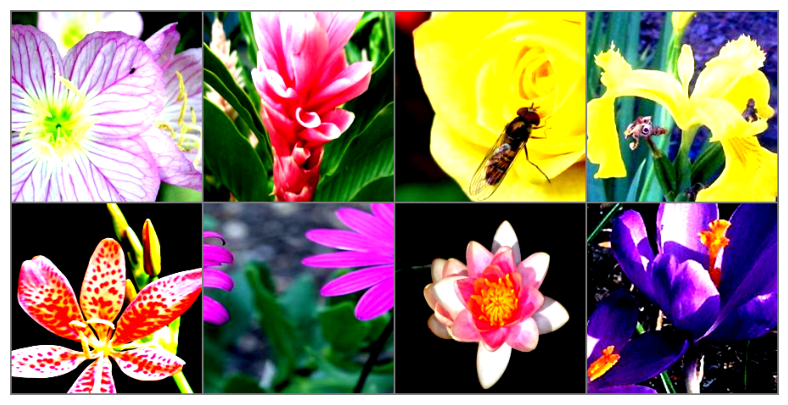

In [19]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Function to display a batch of images with labels
def show_sample_images(dataloader, class_names):
    # Get a batch of images and labels
    images, labels = next(iter(dataloader))

    # Make a grid from batch and unnormalize images
    images = images[:8]  # Display 8 images for clarity
    out = torchvision.utils.make_grid(images, nrow=4)  # Arrange in a 2x4 grid
    out = out / 2 + 0.5  # Unnormalize

    plt.figure(figsize=(10, 5))
    plt.imshow(out.permute(1, 2, 0))  # Convert from Tensor image
    plt.axis('off')

    # Print labels
    labels = labels[:8]  # Only first 8 labels
    label_names = [class_names[label] for label in labels]
    print("Labels:", label_names)

# Load class names from the dataset
class_names = train_dataset.dataset.classes  # Assumes the classes are in the original dataset

# Show sample images from the training set
show_sample_images(dataloaders['train'], class_names)


In [7]:
# Show sample images from the training dataset
print("Sample images from the training dataset:")

# Load a pre-trained model (ResNet18)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)  # Adjusted to 100 classes


Sample images from the training dataset:


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 90.4MB/s]


In [8]:
model = model.to(device)

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
# Training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

In [10]:
# Train the model
model_trained = train_model(model, dataloaders, criterion, optimizer, num_epochs=1)

# Save the trained model
torch.save(model_trained.state_dict(), 'flower_classification_resnet18.pth')
print("Model trained and saved as 'flower_classification_resnet18.pth'")

# Evaluate the model and visualize predictions on the validation set
def visualize_predictions(model, dataloader, num_images=6):
    model.eval()
    images, labels, predictions = [], [], []
    with torch.no_grad():
        for i, (inputs, labels_batch) in enumerate(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            images.append(inputs.cpu())
            labels.extend(labels_batch.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
            if len(images) >= num_images:
                break

    for i in range(num_images):
        print(f'True: {labels[i]}, Pred: {predictions[i]}')

# Show some predictions on the validation set
print("Sample predictions on the validation dataset:")
visualize_predictions(model_trained, dataloaders['val'], num_images=6)

Epoch 1/1
Train Loss: 3.4371 Acc: 0.2850
Val Loss: 1.8816 Acc: 0.6334
Model trained and saved as 'flower_classification_resnet18.pth'
Sample predictions on the validation dataset:
True: 0, Pred: 84
True: 0, Pred: 49
True: 0, Pred: 84
True: 0, Pred: 84
True: 0, Pred: 83
True: 0, Pred: 84


In [11]:
# Train the model
model_trained = train_model(model, dataloaders, criterion, optimizer, num_epochs=5)

# Save the trained model
torch.save(model_trained.state_dict(), 'flower_classification_resnet18.pth')
print("Model trained and saved as 'flower_classification_resnet18.pth'")

# Evaluate the model and visualize predictions on the validation set
def visualize_predictions(model, dataloader, num_images=6):
    model.eval()
    images, labels, predictions = [], [], []
    with torch.no_grad():
        for i, (inputs, labels_batch) in enumerate(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            images.append(inputs.cpu())
            labels.extend(labels_batch.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
            if len(images) >= num_images:
                break

    for i in range(num_images):
        print(f'True: {labels[i]}, Pred: {predictions[i]}')

# Show some predictions on the validation set
print("Sample predictions on the validation dataset:")
visualize_predictions(model_trained, dataloaders['val'], num_images=6)

Epoch 1/5
Train Loss: 1.7737 Acc: 0.6627
Val Loss: 0.8886 Acc: 0.8342
Epoch 2/5
Train Loss: 1.1190 Acc: 0.7955
Val Loss: 0.5572 Acc: 0.9090
Epoch 3/5
Train Loss: 0.8017 Acc: 0.8642
Val Loss: 0.3773 Acc: 0.9377
Epoch 4/5
Train Loss: 0.6323 Acc: 0.8864
Val Loss: 0.2834 Acc: 0.9526
Epoch 5/5
Train Loss: 0.5128 Acc: 0.9099
Val Loss: 0.2388 Acc: 0.9514
Model trained and saved as 'flower_classification_resnet18.pth'
Sample predictions on the validation dataset:
True: 0, Pred: 0
True: 0, Pred: 0
True: 0, Pred: 0
True: 0, Pred: 87
True: 0, Pred: 0
True: 0, Pred: 0


In [13]:
import matplotlib.pyplot as plt

In [15]:
import matplotlib.pyplot as plt

# Modified training function to capture and return losses and accuracies for visualization
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # Store the loss and accuracy for each epoch
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Retrain the model and collect metrics
model_trained, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, dataloaders, criterion, optimizer, num_epochs=5)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4676 Acc: 0.9137
Val Loss: 0.2039 Acc: 0.9651
Epoch 2/5
Train Loss: 0.3917 Acc: 0.9271
Val Loss: 0.1956 Acc: 0.9688
Epoch 3/5
Train Loss: 0.3617 Acc: 0.9290
Val Loss: 0.1714 Acc: 0.9676
Epoch 4/5
Train Loss: 0.3157 Acc: 0.9403
Val Loss: 0.1568 Acc: 0.9738
Epoch 5/5
Train Loss: 0.2988 Acc: 0.9420
Val Loss: 0.1399 Acc: 0.9726


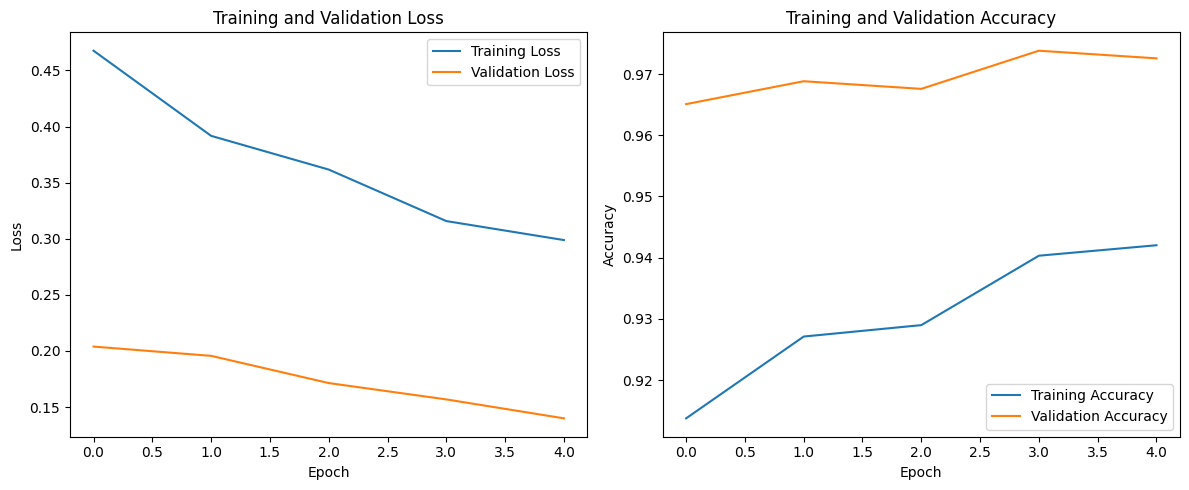

In [16]:
# Plotting the losses
plt.figure(figsize=(12, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
